# Reproducing Neutron Distribution from Miller's paper

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
import scipy as sp
from scipy.fft import fftfreq, fftshift, ifftshift
from scipy.fft import fft, ifft, fft2, ifft2

We want to reproduce figure 1 of [Miller's paper](http://arxiv.org/abs/0705.2409) which shows the neutron charge density. We use the parameterizations in [Kelly](https://link.aps.org/doi/10.1103/PhysRevC.70.068202) for the neutron form factors, 

$$ G_{E n}\left(Q^2\right)=\frac{A \tau}{1+B \tau} G_D\left(Q^2\right), \quad \frac{G_{M n}\left(Q^2\right)}{\mu_n} = \frac{1 + a_1\tau}{1 + b_1 \tau + b_2 \tau^2 + b_3 \tau^3} $$

where $ G_D=\left(1+Q^2 / \Lambda^2\right)^{-2} $, $ \Lambda^2 = 0.71 (GeV/c)^2 $, $\mu_n = -1.91$, and $ \tau = Q^2/\left(4m_p^2\right) $. The parameters $ (A, B, a_i, b_i) $ are given by

$$ A = 1.70 \pm 0.04, \quad B = 3.30 \pm 3.32,\quad a_1 = 2.33 \pm 1.4, \quad b_1 = 14.72 \pm 1.7, \quad b_2 = 24.20 \pm 9.8, \quad b_3 = 84.1 \pm 41 $$

In [5]:
A = 1.70
B = 3.30
a = [1, 2.33]
b = [1, 14.72, 24.20, 84.1]

def GEn(Qsq):
    tau = Qsq/(4*0.938**2)
    return A*tau / (1 + B*tau) / (1 + Qsq / 0.71)**2

def GMn(Qsq):
    tau = Qsq/(4*0.938**2)
    return (a[0] + a[1]*tau) / (b[0] + b[1]*tau + b[2]*tau**2 + b[3]*tau**3)

We try to verify the functional forms with Fig. 1 of [Kelly](https://link.aps.org/doi/10.1103/PhysRevC.70.068202):

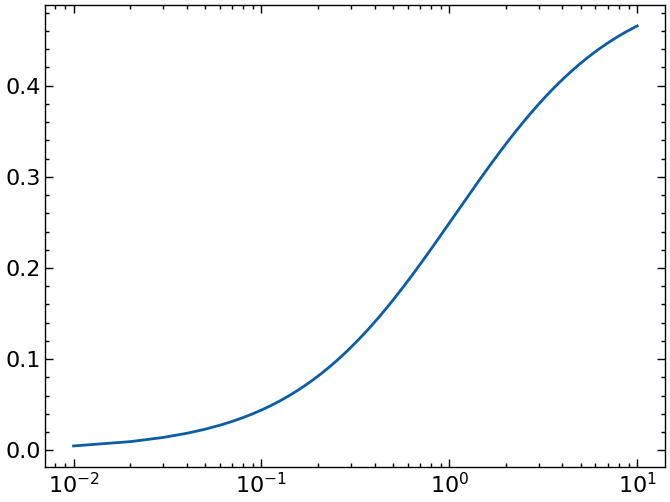

In [10]:
Qsqvals = np.linspace(10**(-2), 10, 1000)
plt.semilogx(Qsqvals, GEn(Qsqvals)*(1 + Qsqvals / 0.71)**2)
plt.show()

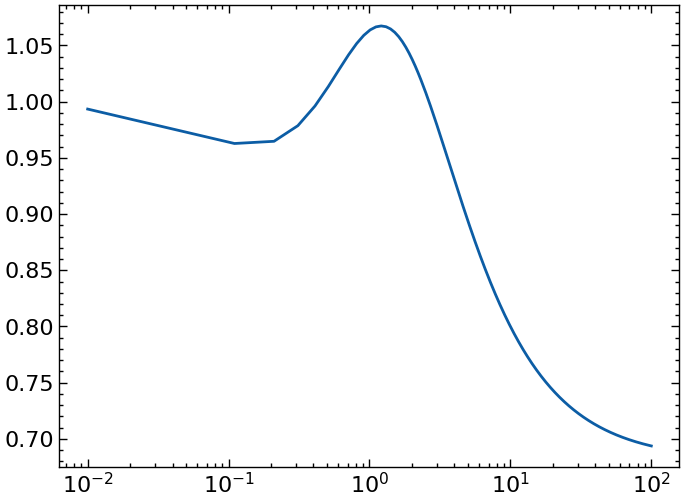

In [13]:
Qsqvals = np.linspace(10**(-2), 100, 1000)
plt.semilogx(Qsqvals, GMn(Qsqvals)*(1 + Qsqvals / 0.71)**2)
plt.show()

Good, it looks the same. Next, we need to do the following fourier transform:

$$ \rho(\mathbf{b}) = \int \frac{d^2 \mathbf{Q}}{(2\pi)^2} F_1\left(|\mathbf{Q}| = \sqrt{Q^2}\right) e^{i \mathbf{Q}\cdot\mathbf{b}}, \quad F_1\left(Q^2\right) = \frac{G_{E n}\left(Q^2\right) + \tau G_{M n}\left(Q^2\right)}{1 + \tau} $$

Let's first see how $F_1(Q)$ looks like

In [5]:
def GEn(Q):
    tau = (Q**2)/(4*0.938**2)
    return A*tau / (1 + B*tau) / (1 + Q**2 / 0.71)**2

def GMn(Q):
    tau = (Q**2)/(4*0.938**2)
    return -1.91*(a[0] + a[1]*tau) / (b[0] + b[1]*tau + b[2]*tau**2 + b[3]*tau**3)

def F1n(Q):
    tau = (Q**2)/(4*0.938**2)
    return (GEn(Q) + tau*GMn(Q)) / (1 + tau)

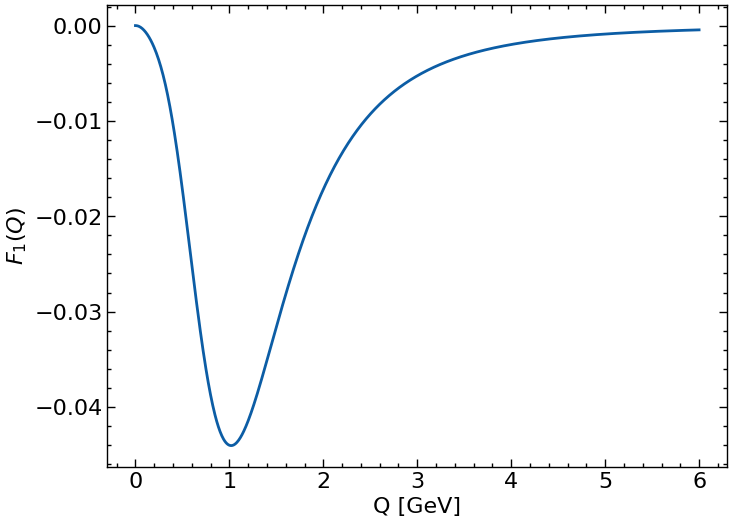

In [23]:
Qvals = np.linspace(0,6,1000)
plt.plot(Qvals, F1n(Qvals))
plt.ylabel('$F_1(Q)$')
plt.xlabel('Q [GeV]')
plt.show()

Looks about right. Now we try to fourier transform this.

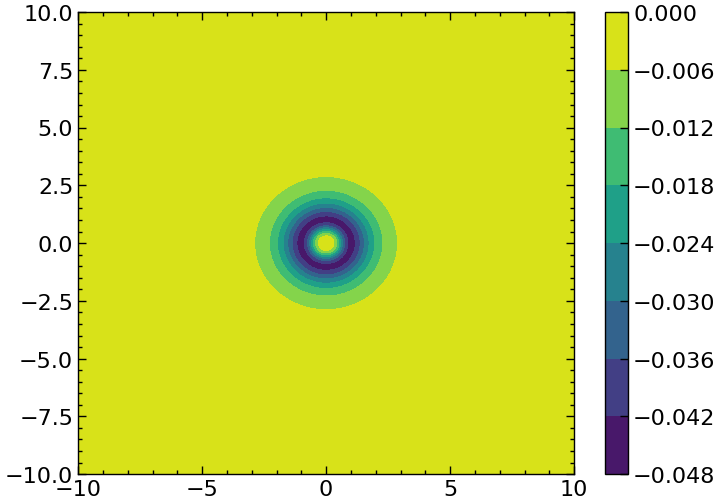

In [6]:
A = 1.70
B = 3.30
a = [1, 2.33]
b = [1, 14.72, 24.20, 84.1]

def GEn(Q):
    tau = (Q**2)/(4*0.938**2)
    return A*tau / (1 + B*tau) / (1 + Q**2 / 0.71)**2

def GMn(Q):
    tau = (Q**2)/(4*0.938**2)
    return -1.91*(a[0] + a[1]*tau) / (b[0] + b[1]*tau + b[2]*tau**2 + b[3]*tau**3)

def F1n(Q):
    tau = (Q**2)/(4*0.938**2)
    return (GEn(Q) + tau*GMn(Q)) / (1 + tau)

def F1n2d(Qx,Qy):
    return F1n(np.sqrt(Qx**2 + Qy**2))

Nx, Ny = 501, 501
x = np.linspace(-10,10,Nx)
y = np.linspace(-10,10,Ny)

xvals, yvals = np.meshgrid(x , y)
rho_Q = F1n2d(ifftshift(xvals),ifftshift(yvals))
plot = plt.contourf(xvals, yvals, fftshift(rho_Q))
plt.colorbar(plot)
plt.show()

In [7]:
rho_b = np.real(fftshift(np.diff(x)[0]*np.diff(y)[0]*fft2(rho_Q) / ((2*np.pi)**2)))
bx = fftshift(fftfreq(len(x), np.diff(x)[0] / (2*np.pi)))
by = fftshift(fftfreq(len(y), np.diff(y)[0] / (2*np.pi)))
bxvals, byvals = np.meshgrid(bx,by)

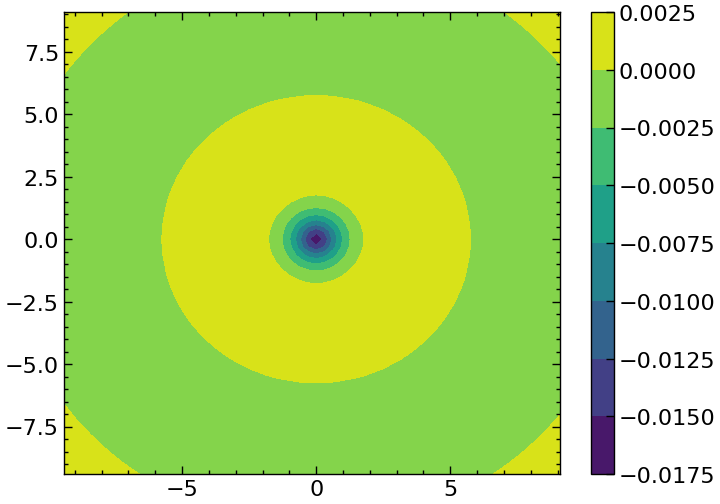

In [8]:
plot = plt.contourf(bxvals[220:280,220:280], byvals[220:280,220:280], rho_b[220:280,220:280])
plt.colorbar(plot)
plt.show()

We show a radial plot by plotting the $b_y = 0$ values.

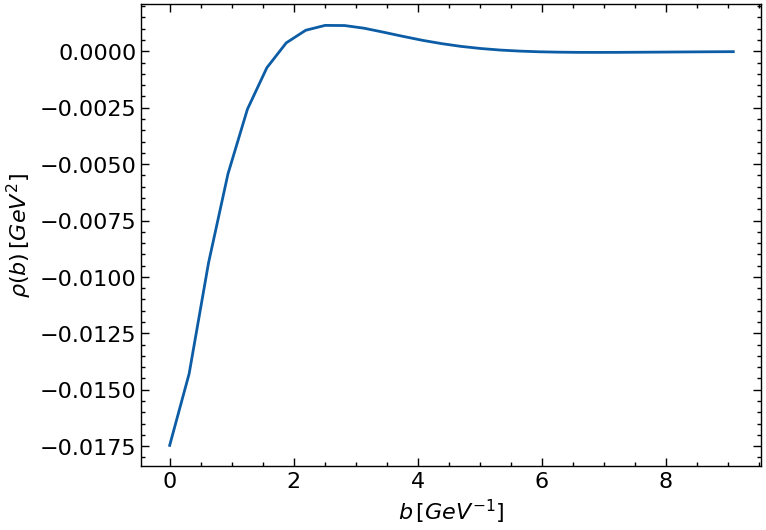

In [9]:
plt.plot(bxvals[250,250:280], rho_b[250,250:280])
plt.xlabel(r'$b\, [GeV^{-1}]$')
plt.ylabel(r'$ \rho(b)\, [GeV^2]$')
plt.show()

To convert to units of [fm], we use the conversion factor $1\, \text{fm} = 5.068\, \text{GeV}^{-1}$. This implies that $\rho(b)\, [\text{fm}^{-2}] = (5.068^2) (\rho(b)\, [\text{GeV}^2])$

In [10]:
bfm = bxvals[250,250:500] / 5.068
rho_b_fm = rho_b[250, 250:500] * ((5.068)**2)

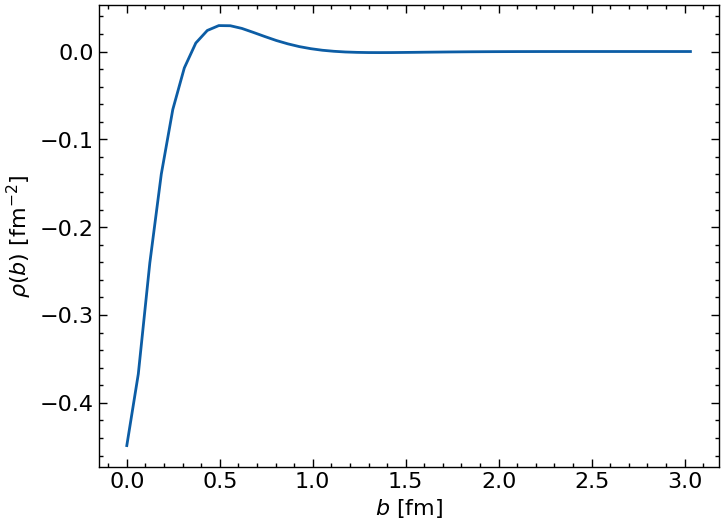

In [13]:
plt.plot(bfm[0:50], rho_b_fm[0:50])
plt.xlabel(r'$b$ [fm]')
plt.ylabel(r'$ \rho(b)$ [fm$^{-2}$]')
plt.show()